In [299]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import ToTensor

%matplotlib inline

In [300]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [301]:
len(pd.read_csv("data/train.csv", header=None))

21250

In [302]:
class ImageColorizerDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.annotations_file = pd.read_csv(os.path.join(root_dir, "train.csv" if train else "test.csv"), header=None)
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations_file)

    def __getitem__(self, idx: int):
        img_path = os.path.join(self.root_dir, "thumbs25k_gray", self.annotations_file.iloc[idx, 0])
        target_path = os.path.join(self.root_dir, "thumbs25k", self.annotations_file.iloc[idx, 0])

        img = read_image(img_path).numpy()
        target = read_image(target_path).numpy()
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            target = self.target_transform(target)
        
        return img, target

In [303]:
train_data = ImageColorizerDataset(root_dir="./data", train=True, transform=ToTensor(), target_transform=ToTensor())
test_data = ImageColorizerDataset(root_dir="./data", train=False, transform=ToTensor(), target_transform=ToTensor())

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Text(0.5, 1.0, 'Colorized Image')

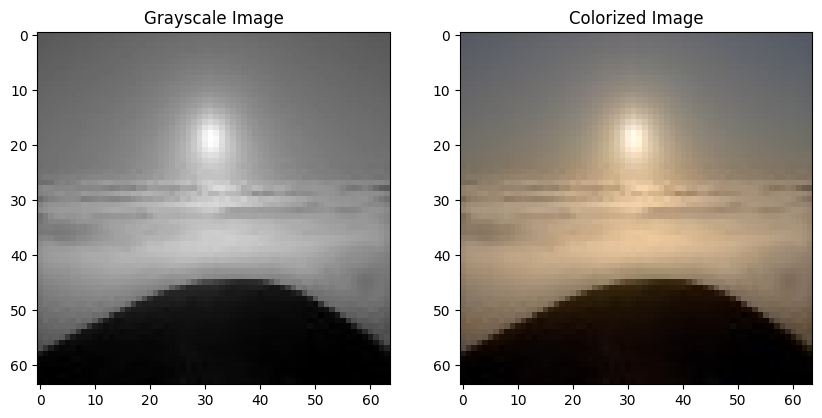

In [316]:
img, target = next(iter(train_dataloader))

img = img.permute(0, 3, 1, 2)
target = target.permute(0, 3, 1, 2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0].squeeze(), cmap="gray")
ax[0].set_title("Grayscale Image")

ax[1].imshow(target[0], interpolation="nearest")
ax[1].set_title("Colorized Image")

In [317]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [318]:
class ImageColorizerNetwork(nn.Module):
    def __init__(self):
        """Convolutional neural network for colorizing grayscale images.
        Takes a 1x64x64 image as input and outputs a 3x64x64 image.
        Multiple blocks of convolution->maxpool->batchnorm->relu are used.
        """
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(16, 8, kernel_size=1, stride=1, padding=8),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(8, 3, kernel_size=1, stride=1, padding=6),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.conv_stack(x)


In [319]:
model = ImageColorizerNetwork().to(device)
print(model)

ImageColorizerNetwork(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), padding=(5, 5))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(64

In [320]:
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, optimizer: torch.optim.Optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [321]:
loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")


Epoch 1
-------------------------------


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[64, 64, 1, 64] to have 1 channels, but got 64 channels instead